<a href="https://colab.research.google.com/github/yoav1131/Deep-Learning-Course/blob/main/Variational_Autoencoder_v01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Autoencoders

In this notebook we train a veriational autoencoder. Despite the similarity in archtecture and name, variational autoencoders are quite different from autoencoders in their task and operation. As in the outoencoders notebook, we again use the MNIST dataset for hadwritten digits.

In [2]:
import torch
import torchvision
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Since we are going to deal with a bit of randomization here, let's initialize the seed for consistency.

In [3]:
# Set random seed

torch.manual_seed(1)
torch.cuda.manual_seed(1)

**MNIST dataset:** since we are all quite familiar by now with MNIST, we can directly load the images by batches. Note that we keep the division of the data into training and test sets to get some sense on how the variational autoencoder adapts during the training procedure. Nonetheless, there are no labels used here as this in unsupervised learning.

In [10]:
batch_size = 256

train_loader = torch.utils.data.DataLoader(
    MNIST(root="./data", train=True, download=True,
          transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    MNIST(root="./data", train=False, download=True,
          transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)


We defined the following aid function for viewing images

In [39]:
# Desplay routing

def display_images(in_, out, n=1, label=None, count=False):
  for N in range(n):
      if in_ is not None:
        in_pic = in_.data.cpu().view(-1, 29, 28)
        plt.figure(figsize=(15, 4))
        plt.suptitle(label + ' - real test data / reconstuctions', color='w', fontsize=16)
        for i in range(4):
          plt.subplot(1, 4, i+1)
          plt.imshow(in_pic[i+4*N], cmap='Greys_r')
          plt.axis('off')

      out_pic = out.data.cpu().view(-1, 28, 28)
      plt.figure(figsize=(15, 6))
      for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.imshow(out_pic[i+4*N], cmap='Greys_r')
        plt.axis('off')
        if count: plt.title(str(4 * N + i), color='w')


# Train Function

Let's start with the ELBO loss, which is the more non-trivial aspect of this implementation. This loss is comprised of rwo terms:



1.   The KL distance, $D_{KL}(q_{\theta}(z|y)||p_{\phi}(z))$ which captures the distance of the latent distribution from a desired Gaussian one. What we divergence (assuming both distributions are Gaussian) becomes

$D_{KL}(q_{\theta}(z|y)||p_{\phi}(z)) = \frac{1}{2}(Tr(\Sigma)+\mu^T\mu - k - logdet(\Sigma))$ =

$\sum_{i=1}^{k}(exp \{\log \sigma_{i}^{2}\} + \mu_{i}^{2} - 1 - log\sigma_{i}^{2})$.

2.   The *reconstruction loss*, $-\mathbb{E}_{\mathbf{z} \sim q_{\theta}(\mathbf{z} \mid \mathbf{y})} \big[ \log p_{\phi}(\mathbf{y} \mid \mathbf{z}) \big]$. This term represents how closely the output matches the input. We will not directly compute it (i.e., we will not actually take average over the conditional distribution of $z$ for each input $y$). What we will do instead is approximate it as the cross-entropy loss, and in particular, as the MNIST pixels take values in $[0, 1]$, we approximate its pixels as taking values in the *binary set* $\{0, 1\}$, and use the binary cross entropy loss, namely

$-\sum_{i} (y_i log \hat{y}_{i} + (1-y_i)log(1-\hat{y}_{i}))$,

with $\hat{y}_{i} = p_{\phi}(y_i|z) \sim p(y_{i}=1|z)$.

The resulting method for computing the ELBO loss is given below:


In [6]:
# Reconstruction + KL divergence losses summed over all elements and batch

def loss_function(y_hat, y, mu, logvar):
  BCE = nn.functional.binary_cross_entropy(
      y_hat, y.view(-1, 784), reduction='sum'
  )

  KLD = 0.5 * torch.sum(logvar.exp() + mu.pow(2) - 1 - logvar)

  return BCE + KLD

We are now ready to define the training function. A we did in the autoencoder example, we will save the outputs along the epochs for later visualization. However, here we will use the test data for that aim, namely, after each epoch we forward the test data through the model and save the latent varuables (and the labels of each digit) in the structure *codes*.

In [18]:
def train(model, train_loader, test_loader, num_epochs=10, learning_rate=1e-3):
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
  codes = dict(mu=list(), logsig2=list(), label=list())
  for epoch in range(num_epochs):
    # Training
    if epoch > 0:
      model.train()
      train_loss = 0
      for y, _ in train_loader:
        # =============forward=============
        y_hat, mu, logvar = model(y)
        loss = loss_function(y_hat, y, mu, logvar)
        train_loss += loss.item()
        # =============backward=============
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
      # =============log=============
      print(f'===> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')

    # Testing

    means, logvars, labels = list(), list(), list()
    with torch.no_grad():
      model.eval()
      test_loss = 0
      for y, label in train_loader:
        # =============forward=============
        y_hat, mu, logvar = model(y)
        test_loss += loss_function(y_hat, y, mu, logvar).item()
        # =============log=============
        # the .detach() statements are added to make sure that no gradients are computed for these variables
        means.append(mu.detach().cpu())
        logvars.append(logvar.detach().cpu())
        labels.append(label.detach().cpu())

    # =============log=============
    codes['mu'].append(torch.cat(means, dim=0))
    codes['logsig2'].append(torch.cat(logvars, dim=0))
    codes['label'].append(torch.cat(labels, dim=0))
    test_loss /= len(test_loader.dataset)
    print(f'===> Test set loss: {test_loss:.4f}')

  return y, mu, codes



# Variational Autoencoder

Both the encoder and the decoder are comprised of two fully connected layers of dimensional $28^2 → k^2 → k$, with intermediate ReLU activation. To guarentee tht the output is indeed takes values in the range $[0, 1]$ (so that it can be trained with the binary cross entropy loss), we use a sigmoid output layer.

The encoder outputs are the vectors of means $\{ \mu_i \}$ ane log variances
$\{ log σ_{i}^{2} \}$. The decoder input is generated via the reparameterization trick in the method *reparameterise*, which randomizes a set of standard normal random variables $\{ \epsilon_{i} \} $ and generates the latent $z$ via

$z_{i} = exp\{ \frac{1}{2} log\sigma_{i}^{2} \} \cdot \epsilon_{i} + \mu_{i} $.

In [8]:
class VAE(nn.Module):
  def __init__(self, k):
    super(VAE, self).__init__()

    self.encoder = nn.Sequential(
        nn.Linear(784, k ** 2),
        nn.ReLU(),
        nn.Linear(k ** 2, k * 2)
    )

    self.decoder = nn.Sequential(
        nn.Linear(k, k ** 2),
        nn.ReLU(),
        nn.Linear(k ** 2, 784),
        nn.Sigmoid(),
    )

    self.k = k

  def reparameterise(self, mu, logvar):
    if self.training:
      std = logvar.mul(0.5).exp_()
      eps = std.data.new(std.size()).normal_()
      return eps.mul(std).add_(mu)
    else:
      return mu

  def forward(self, x):
    mu_logvar = self.encoder(x.view(-1, 784)).view(-1, 2, self.k)
    mu = mu_logvar[:, 0, :]
    logvar = mu_logvar[:, 1, :]
    z = self.reparameterise(mu, logvar)
    return self.decoder(z), mu, logvar

Let's generate a model with latent dimension $k=20$:

In [19]:
k = 20
model = VAE(k)
y, mu, codes = train(model, train_loader, test_loader)

===> Test set loss: 3263.3377
===> Epoch: 1 Average loss: 188.9702
===> Test set loss: 825.7055
===> Epoch: 2 Average loss: 133.1803
===> Test set loss: 698.8418
===> Epoch: 3 Average loss: 121.1948
===> Test set loss: 659.8877
===> Epoch: 4 Average loss: 116.0186
===> Test set loss: 633.2040
===> Epoch: 5 Average loss: 113.2289
===> Test set loss: 623.1974
===> Epoch: 6 Average loss: 111.4878
===> Test set loss: 611.5793
===> Epoch: 7 Average loss: 110.2231
===> Test set loss: 605.7615
===> Epoch: 8 Average loss: 109.2613
===> Test set loss: 600.0436
===> Epoch: 9 Average loss: 108.5090
===> Test set loss: 591.9257


**Generation of New Images:** Let's see what samples are generated by the randomized decoder. To that aim, we just feed a Gaussian random input to the decoder, and the output is some new digits spawned by the generative model.

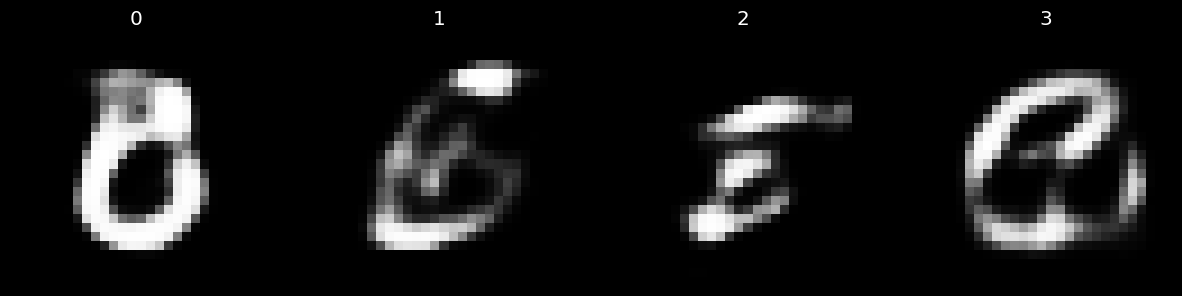

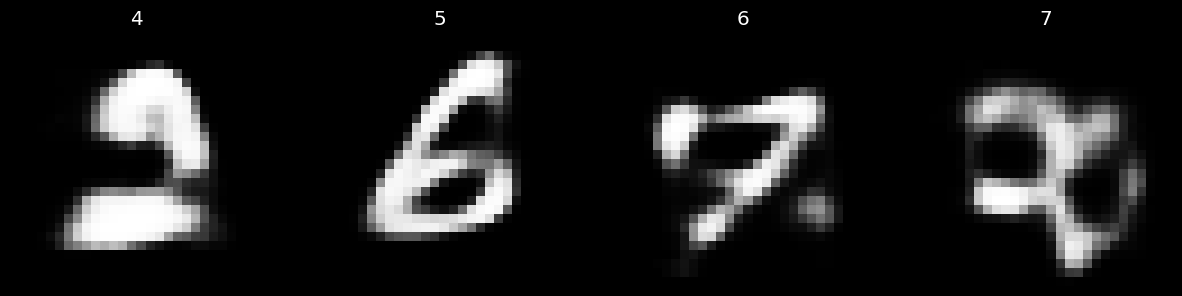

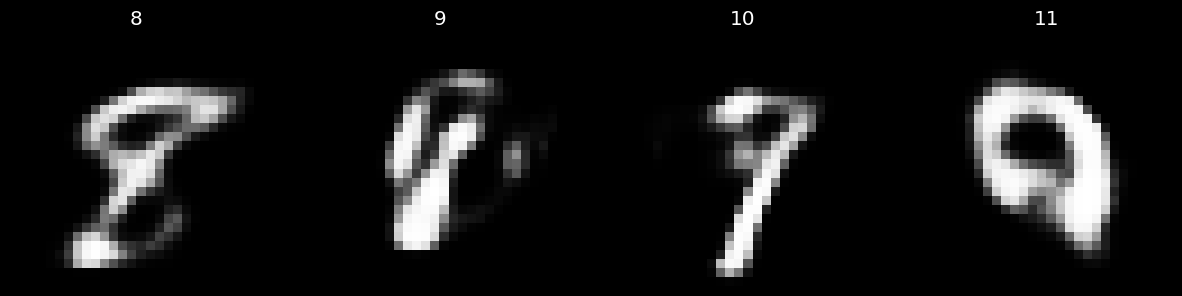

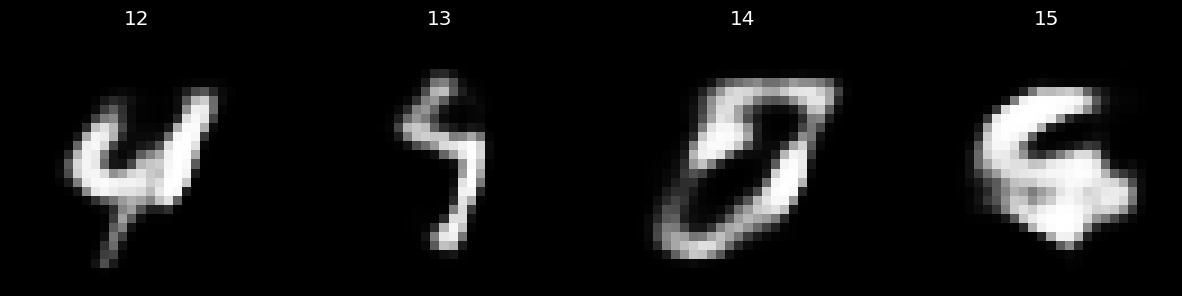

In [40]:
# Generating a few samples

N = 16
z = torch.randn((N, k)).to(device)
sample = model.decoder(z)
display_images(None, sample, N // 4, count=True)

**Interpolation in the Latent Space:** Next, let's interpolate in the latent space. To that aim, we select a pair of outputs from the test parts in the final epoch, along with their corresponding latent variables. When passing these latent variables through the decoder, we get a reaonable reconstruction, as we see below:

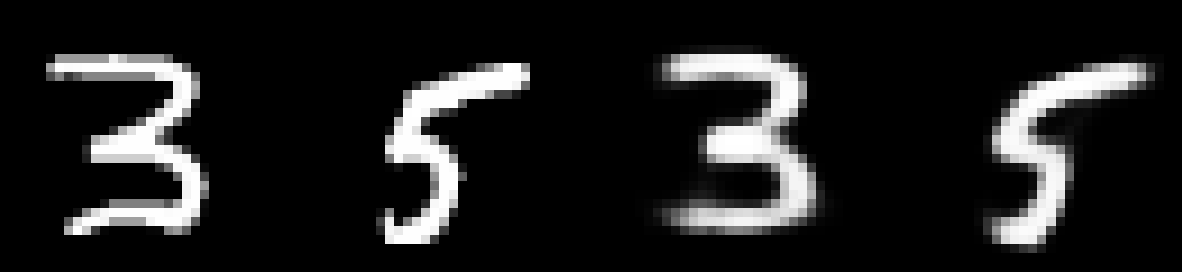

In [41]:
# Choose starting and ending point for the interpolation -> shows original and reconstructed

A, B = 1, 12
sample = model.decoder(torch.stack((mu[A].data, mu[B].data), 0))
display_images(None, torch.stack(((
    y[A].data.view(-1),
    y[B].data.view(-1),
    sample.data[0],
    sample.data[1]
))
, 0))

We can now interpolate between the latent variables, demonstrating the smooth transition in the images domain.

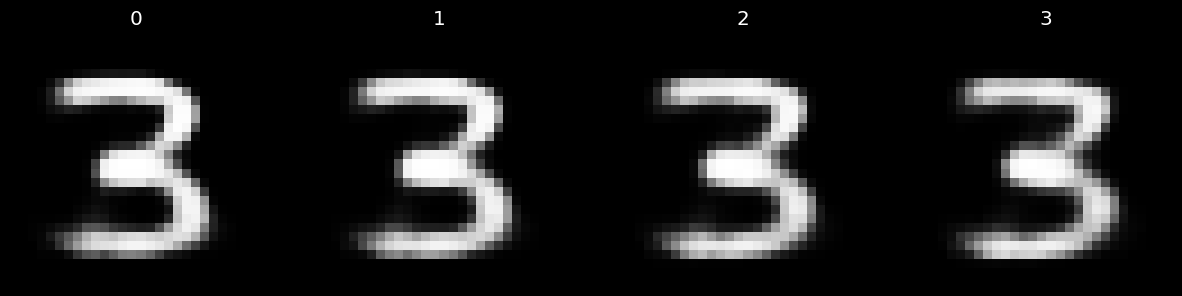

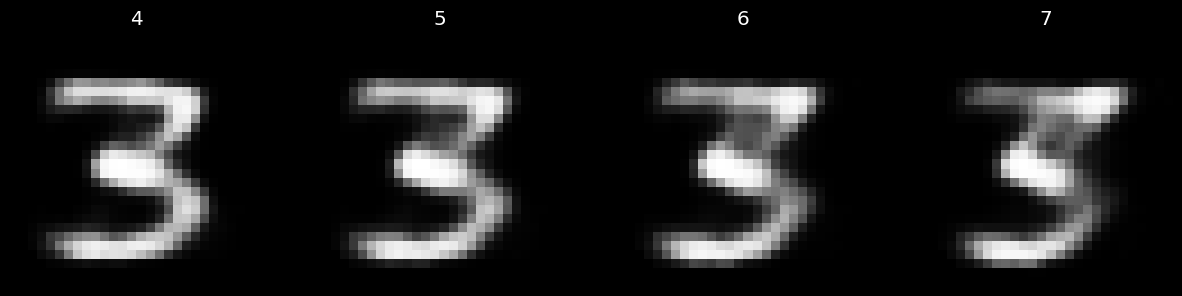

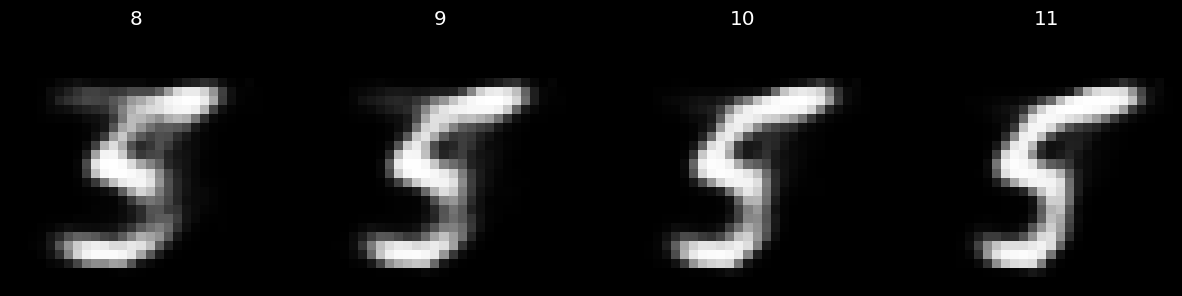

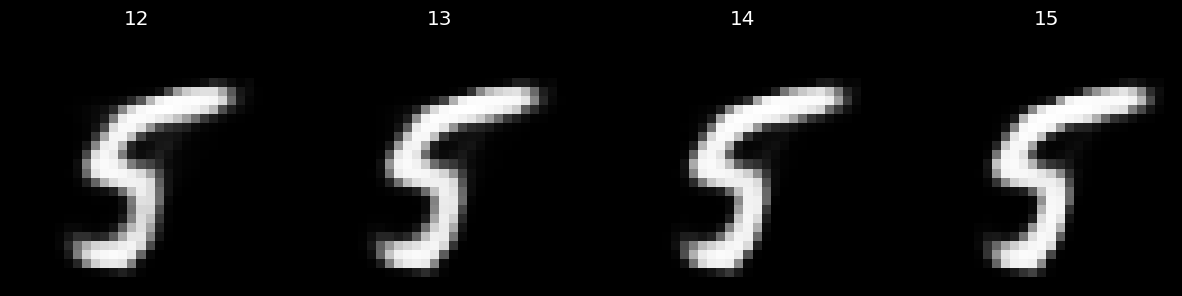

In [42]:
# Perform an interpolation between input A and B, in N steps
code = torch.Tensor(N, 20)
sample = torch.Tensor(N, 28, 28)
for i in range(N):
  code[i] = i / (N-1) * mu[B].data + (1 - i / (N - 1) ) * mu[A].data
sample = model.decoder(code)
display_images(None, sample, N // 4, count=True)

# Latent Space Visualisation

Finally, we are interested in seeing how different digits are mapped into different mean values in the latent space. The problem in visualizing this is that the latent, mean $\mu$ is a $20 \times 1$ vector, which meanjs that in order to have something that we can visualize, we have to project it into a two dimensional subspace.

There are many wayes to project high dimensional vectors $z_{1}, \dots, Z_{N}$ into lower dimensional ones $v_{1}, \dots, v_{N}$, the first option that comes to mind is clearly principle component analysis (PCA). However, PCA aims towards maximizing variance, while we are specifically interested in a projection which preserves the similarities between different vectors. To that aim, we use t-distributed stochastic neighbor ambedding (TSNE) method.

On a nutshell, the TSNE method measures similarity between the high dimensional vector $\{ z_{i} \}$ using a conditional Gaussian distribution (i.e., the distance between $z_{i}$ and $z_{j}$ is measured as the Gaussian distribution with mean $z_{i}$ evaluated at $z_{j}$), and in the lower dimensional space using a Cauchy distribution (which is a t-student distribution with one degree of freedom). Then, it aims at finding the vectors $\{ v_{i} \}$ for which these conditional distribution distance measures are most similar to those of $\{ z_{i} \}$ in the sense of minimal KL distance.

The TSNE method is highly used for visualization in machine learning aplications, and fortunatley for us, it is provided in the *sklearn* package.

In [25]:
from sklearn.manifold import TSNE

We next focus on $1000$ test latent mean values in epochs $0, 5, 9$, compute the TSNE 2D reprentations in the list V, and save the corresponding labels in the list L

In [37]:
Z, L, V = list(), list(), list() # input classes embeddings
N = 1000 # sample per epoch
epochs = (0, 5 ,9)
for epoch in epochs:
  Z.append(codes['mu'][epoch][:N])
  V.append(TSNE(n_components=2).fit_transform(Z[-1]))
  L.append(codes['label'][epoch][:N])

We next visualize twoD projected means, assigning a different color for each label. We can see that from epoch $0$, the classes are spreading everywhere, with only little concentration. As the model is trained, the latent space becomes more well defined and classes (digits) starts to form clusters.

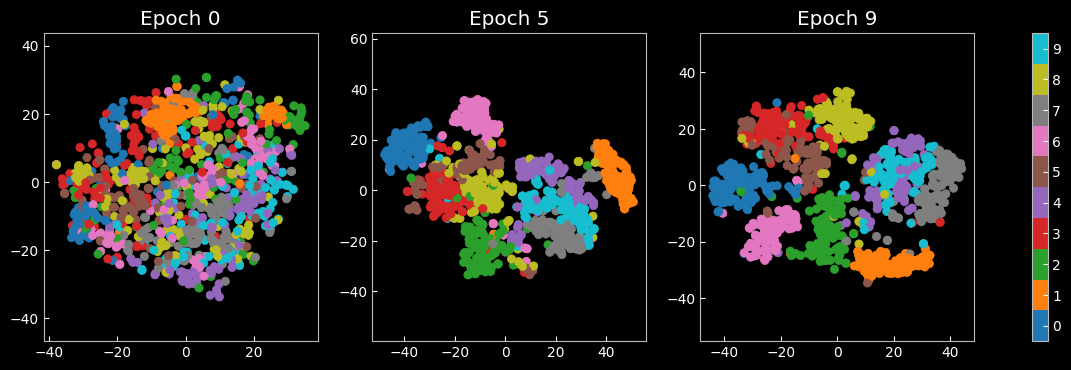

In [38]:
plt.style.use(['dark_background', 'bmh'])
plt.rc('axes', facecolor='k')
plt.rc('figure', facecolor='k')
plt.rc('figure', figsize=(15, 4), dpi=100)
f, a = plt.subplots(ncols=3)
for i, e in enumerate(epochs):
  s = a[i].scatter(V[i][:, 0], V[i][:, 1], c=L[i], cmap='tab10')
  a[i].grid(False)
  a[i].set_title(f'Epoch {e}')
  a[i].axis('equal')

f.colorbar(s, ax=a[:], ticks=np.arange(10), boundaries=np.arange(11)-0.5)
